# ***LOAD LIBRARIES***
---
Import required libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum ,lit,to_timestamp,max, datediff, current_date
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import gc
import mlflow
import mlflow.spark
import os
import multiprocessing



In [4]:
if 'session_spark' in locals():
    spark.stop()


In [5]:
# create and configure a local pySpark session for distributed data processing

session_spark =SparkSession.builder.appName("housing-prices").getOrCreate()
session_spark
print(f"Cores used: {session_spark.sparkContext.defaultParallelism}")
#clear unnecessary RAM
gc.collect() 


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/14 20:12:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Cores used: 4


253

# ***DATA EXPLORATION***
---
Inspect dataset structure, schema, and basic statistics to understand the data.

In [10]:
#LOAD DATASET 
df = session_spark.read.csv('/kaggle/input/datasets/seg-cl/OnlineRetail.csv',
                              header= True ,   #first row contains column names
                              inferSchema= True # detects data types for each column
                            )

In [11]:
#returns the total number of rows
print ("The total number of rows is :", df.count())

The total number of rows is : 541909


In [12]:
#returns the first  10 rows
print ("The first 10 rows:")
df.show(10)

The first 10 rows:
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|12/1/2010 8:26|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|12/

In [13]:
#Displays the schema of the DataFrame
print("Shows the schema of the DataFrame")
df.printSchema()

Shows the schema of the DataFrame
root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [14]:
#select numerical columns
numeric_columns =df.select([
                 nom for nom , dtype in df.dtypes 
                 if dtype in (('int', 'bigint', 'double', 'float'))
                ])
#select categorical columns
catg_columns= df.select([
               nom for nom ,dtype in df.dtypes 
               if dtype in("string ") 
                ])

#display  numerical and categorical columns
print("numeric columns")
numeric_columns.show(5)
print("categorical_columns")
catg_columns.show(5)

numeric columns
+--------+---------+----------+
|Quantity|UnitPrice|CustomerID|
+--------+---------+----------+
|       6|     2.55|     17850|
|       6|     3.39|     17850|
|       8|     2.75|     17850|
|       6|     3.39|     17850|
|       6|     3.39|     17850|
+--------+---------+----------+
only showing top 5 rows

categorical_columns
+---------+---------+--------------------+--------------+--------------+
|InvoiceNo|StockCode|         Description|   InvoiceDate|       Country|
+---------+---------+--------------------+--------------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|12/1/2010 8:26|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|12/1/2010 8:26|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|12/1/2010 8:26|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|12/1/2010 8:26|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|12/1/2010 8:26|United Kingdom|
+---------+---------+--------------------+--------------+----------

In [15]:
#computes and displays the  summury statistics 
print("display summury statistics   ")
df.select(numeric_columns.columns).describe().show()

display summury statistics   


+-------+------------------+-----------------+------------------+
|summary|          Quantity|        UnitPrice|        CustomerID|
+-------+------------------+-----------------+------------------+
|  count|            541909|           541909|            406829|
|   mean|  9.55224954743324|4.611113626088366|15287.690570239585|
| stddev|218.08115785023472|96.75985306118037|1713.6003033215961|
|    min|            -80995|        -11062.06|             12346|
|    max|             80995|          38970.0|             18287|
+-------+------------------+-----------------+------------------+



In [16]:
#Display the numbre of null valuer for each column
null_values = df.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
])
print  ("The number of null values in each column")
null_values.show()

The number of null values in each column


+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [17]:

# compute the numbre of rows where UnitPrice is equal to 0
prix_nuls = df.filter(col("UnitPrice")==0).count()
print(f"Numbre of rows with à zero price : {prix_nuls}")

Numbre of rows with à zero price : 2515


In [18]:
#compute the number of rows where Quantity <  0
quantity_negative = df.filter(df.Quantity < 0).count()
print(f"number of rows with negative Quantity : {quantity_negative}" )

#clear unnecessary RAM
gc.collect() 


number of rows with negative Quantity : 10624


484

In [19]:
#canceled orders
df_annulations = df.filter(F.col("InvoiceNo").startswith("C"))

#display the 10 first canceled orders
df_annulations.show(10)

# compute total canceled orders
print(f" compute total canceled orders : {df_annulations.count()}")

+---------+---------+--------------------+--------+---------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+
|  C536379|        D|            Discount|      -1| 12/1/2010 9:41|     27.5|     14527|United Kingdom|
|  C536383|   35004C|SET OF 3 COLOURED...|      -1| 12/1/2010 9:49|     4.65|     15311|United Kingdom|
|  C536391|    22556|PLASTERS IN TIN C...|     -12|12/1/2010 10:24|     1.65|     17548|United Kingdom|
|  C536391|    21984|PACK OF 12 PINK P...|     -24|12/1/2010 10:24|     0.29|     17548|United Kingdom|
|  C536391|    21983|PACK OF 12 BLUE P...|     -24|12/1/2010 10:24|     0.29|     17548|United Kingdom|
|  C536391|    21980|PACK OF 12 RED RE...|     -24|12/1/2010 10:24|     0.29|     17548|United Kingdom|
|  C536391|    21484|CHICK GREY HOT WA...|     -12|12/1/2010 10:

 compute total canceled orders : 9288


In [20]:
df = df.withColumn("InvoiceDate",to_timestamp(col("InvoiceDate"),"M/d/yyyy H:mm"))
print(df.select("InvoiceDate").dtypes)

df.select("InvoiceDate").show(4)

[('InvoiceDate', 'timestamp')]
+-------------------+
|        InvoiceDate|
+-------------------+
|2010-12-01 08:26:00|
|2010-12-01 08:26:00|
|2010-12-01 08:26:00|
|2010-12-01 08:26:00|
+-------------------+
only showing top 4 rows



# ***VISUALIZATION***
---

In [21]:
pandas_df = df.toPandas()
pandas_df['TotalPrice'] = pandas_df['UnitPrice'] * pandas_df['Quantity']

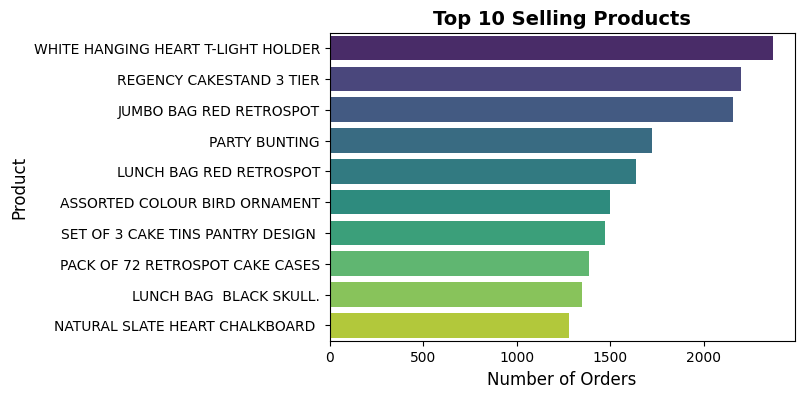

In [22]:
# display the Top 10 Selling Products
plt.figure(figsize=(6, 4))
top_products = pandas_df["Description"].value_counts().head(10)
sns.barplot(y=top_products.index,x=top_products.values, hue=top_products.index,palette="viridis" , legend =False)
plt.title("Top 10 Selling Products", fontsize=14, fontweight='bold')
plt.xlabel("Number of Orders", fontsize=12)
plt.ylabel("Product" ,fontsize=12)

plt.show()

Country
United Kingdom    8187806.364
Netherlands        284661.540
EIRE               263276.820
Germany            221698.210
France             197403.900
Australia          137077.270
Name: TotalPrice, dtype: float64

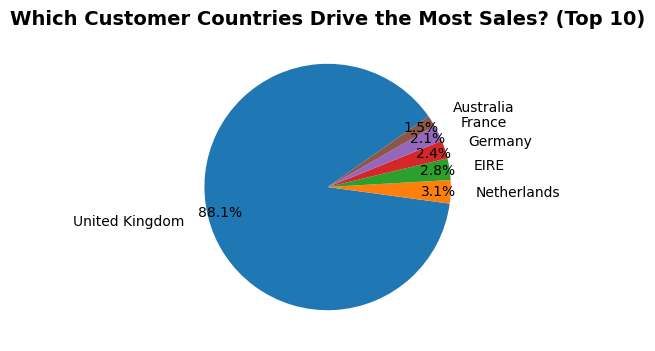

In [24]:
# Calculate sales by country
country_sales = pandas_df.groupby('Country')['TotalPrice'].sum()
display(country_sales.sort_values(ascending=False).head(6))


# Plot pie chart 
top_countries = country_sales.sort_values(ascending=False).head(6)

plt.figure(figsize=(6, 4))
plt.pie(
    top_countries,
    labels=top_countries.index,
    autopct='%1.1f%%',
    startangle=35,
    labeldistance=1.2,
    pctdistance=0.9
)
plt.title('Which Customer Countries Drive the Most Sales? (Top 10)', fontsize=14, fontweight='bold')
plt.show()


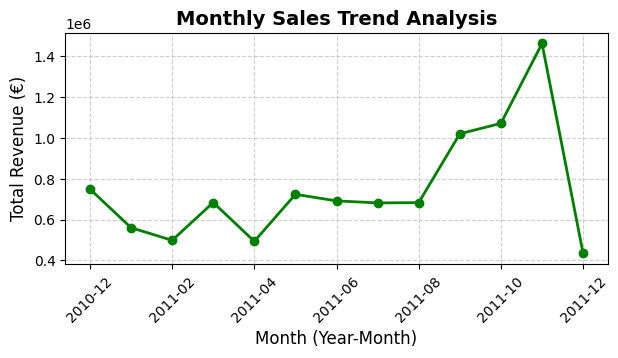

In [25]:
# Display Monthly sales 
pandas_df["Month"] = pandas_df["InvoiceDate"].dt.to_period("M")
monthly_sales = pandas_df.groupby("Month")["TotalPrice"].sum()

# Plotting 
plt.figure(figsize=(7, 3))

monthly_sales.index = monthly_sales.index.astype(str)
monthly_sales.plot(kind="line", marker="o", color="green", linewidth=2)

plt.title("Monthly Sales Trend Analysis", fontsize=14, fontweight='bold')
plt.xlabel("Month (Year-Month)", fontsize=12)
plt.ylabel("Total Revenue (€)", fontsize=12)
plt.xticks(rotation=45) 
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

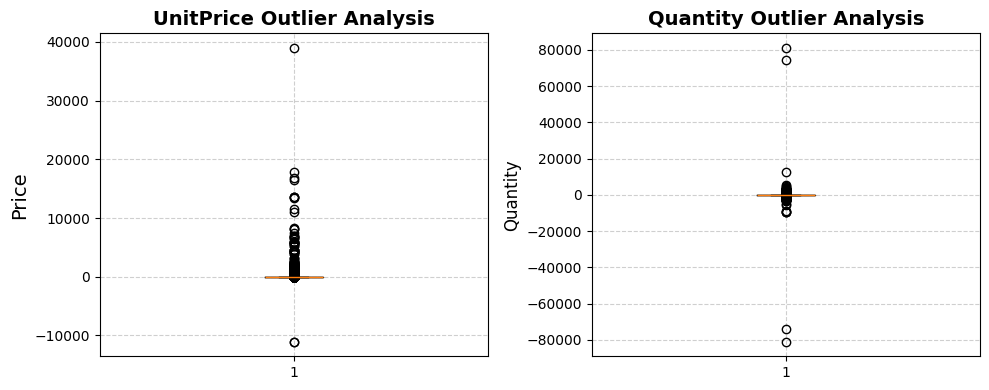

In [26]:
#display the boxplot to show outliers values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

#  Plot 1 : unitprice outliers 
ax1.boxplot(pandas_df["UnitPrice"], vert=True)
ax1.set_title("UnitPrice Outlier Analysis", fontsize=14 ,fontweight='bold')
ax1.set_ylabel("Price", fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.6)

#  Plot 2: quantity outliers 
ax2.boxplot(pandas_df["Quantity"], vert=True)
ax2.set_title("Quantity Outlier Analysis", fontsize=14,fontweight='bold')
ax2.set_ylabel("Quantity",fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


# ***DATA CLEANING***
---

#### ***Duplicate Removal***

In [27]:
#Delete duplicate lines
df_cleaned_ = df.dropDuplicates()


# Nombre de lignes distinctes
distinct_rows = df_cleaned_.count()
# Nombre total de lignes
total_rows = df.count()

# Numbre of duplicate rows
duplicates = total_rows - distinct_rows
print(f"Total rows : {total_rows}")
print(f"Distinct rows : {distinct_rows}")
print(f"Duplicate rows removed: {duplicates}")

#clear unnecessary RAM
gc.collect() 

Total rows : 541909
Distinct rows : 536641
Duplicate rows removed: 5268


5862

#### ***Removing null values***

In [28]:
#filtre rows when CustomerID and Description is not NULL
df_cleaned = df_cleaned_.filter(
    (col("CustomerId").isNotNull())  &  (col("Description").isNotNull())
)
null_values_data_cleaned = df_cleaned.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

#Display the numbre of null valuer for each column
print  ("The number of null values in each column")
null_values_data_cleaned.show()



The number of null values in each column


+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|          0|       0|          0|        0|         0|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [29]:
#filter rows where quantity and unitPrice > 0 ( ( if quantity & unitPrice <=0 ) =invalide transactions Or erreurs)
df_cleaned = df_cleaned.filter(( df.Quantity >0 )&( df.UnitPrice > 0))

#compute lines whene Quantity <= 0 andUnitPrice <=0
quantity_price_negative = df_cleaned.filter(((df.Quantity <= 0))& (df.UnitPrice <= 0 )).count()
print(f"number of lines with negative or null Quantity and UnitPrice : {quantity_price_negative}" )

number of lines with negative or null Quantity and UnitPrice : 0


#### ***Remove Non-Product Transactions***


In [30]:
# Display the most 10 expensive items 
df_cleaned.select("Description", "UnitPrice","Quantity").orderBy(F.col("UnitPrice").desc()).show(10)

+-----------+---------+--------+
|Description|UnitPrice|Quantity|
+-----------+---------+--------+
|    POSTAGE|  8142.75|       1|
|     Manual|  4161.06|       1|
|     Manual|  4161.06|       1|
|     Manual|  3949.32|       1|
|     Manual|  3155.95|       1|
|     Manual|   2500.0|       1|
|     Manual|  2382.92|       1|
|     Manual|  2118.74|       1|
|     Manual|  2053.07|       1|
|     Manual|   2033.1|       1|
+-----------+---------+--------+
only showing top 10 rows



In [31]:
# Remove non-product or irrelevant transactions from the dataset:
# - "Postage": shipping fees, not actual products
# - "Manual": manual orders or administrative entries, not real sales
# - "Discount": discount or adjustment lines, sometimes negative

non_product_codes = ["POST", "manual", "M", "discount"]
df_final = df_cleaned.filter(~F.col("StockCode").isin(non_product_codes))

print(f"rows before  : {df_cleaned.count()}")
print(f"rows after : {df_final.count()}")
print(f" rows removed :{df_cleaned.count()-df_final.count()}")
gc.collect()

rows before  : 392692


rows after : 391314


 rows removed :1378


4258

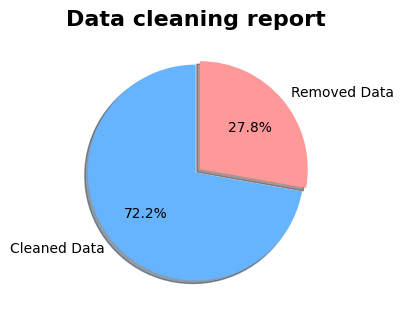

------------------------------
Data cleaning report
------------------------------
Initial Records:   541,909
Cleaned Records:   391,314
Records Removed:   150,595
Percentage Kept:   72.21027884755559%
Percentage Lost:   27.789721152444415%


In [32]:
# Calculate Initial and Final Counts 
total_initial = df.count()
total_final = df_final.count()
total_removed = total_initial - total_final

# Calculate Percentages 
percent_removed = (total_removed / total_initial) * 100
percent_retained = (total_final / total_initial) * 100

# Visualization of Data Loss 

# Data for plotting
labels = ['Cleaned Data', 'Removed Data']
sizes = [total_final, total_removed]
colors = ['#66b3ff', '#ff9999']

fig, ax = plt.subplots(figsize=(4, 4))

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, 
       colors=colors, explode=(0.05, 0), shadow=True)

ax.set_title("Data cleaning report ", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

# print summary report 
print("-" * 30)
print("Data cleaning report")
print("-" * 30)
print(f"Initial Records:   {total_initial:,}")
print(f"Cleaned Records:   {total_final:,}")
print(f"Records Removed:   {total_removed:,}")
print(f"Percentage Kept:   {percent_retained}%")
print(f"Percentage Lost:   {percent_removed:}%")


# ***FEATURE ENGINEERING & PREPROSSING***
---

#### ***RFM ANALYSIS***
RFM (Recency, Frequency, Monetary) is a widely used customer segmentation technique in retail and marketing analytics. It evaluates customer behavior based on three key dimensions:

Recency (R): How recently a customer made a purchase

Frequency (F): How often a customer made purchases

Monetary (M): How much money a customer spent in total

In [33]:
#Calcule the RFM coefficents

## Compute Total price per row 
df_with_total =df_final.withColumn("TotalSum", F.col("Quantity") * F.col("UnitPrice"))


# Define the reference date for Recency calculation 
#(we use the latest purchase date in the dataset as the reference pointt)

max_date = df_with_total.select(F.max("InvoiceDate")).collect()[0][0]
#Create a 'snapshot date' by adding 1 day to the maximum date
#
snapshot_date = F.date_add(F.lit(max_date), 1)

# RFM Aggregation
rfm_df = df_with_total.groupBy("CustomerID").agg(
    F.datediff(snapshot_date, F.max("InvoiceDate")).alias("Recency"),
    F.countDistinct("InvoiceNo").alias("Frequency"),
    F.sum("TotalSum").alias("Monetary")
)


#display
rfm_df.select("Recency", "Frequency", "Monetary").describe().show()

+-------+------------------+-----------------+------------------+
|summary|           Recency|        Frequency|          Monetary|
+-------+------------------+-----------------+------------------+
|  count|              4335|             4335|              4335|
|   mean|  93.2325259515571|4.248212226066897|2019.8350643598635|
| stddev|100.20437538728558| 7.64602384135346| 8936.990391178564|
|    min|                 1|                1|              3.75|
|    max|               374|              206|         279138.02|
+-------+------------------+-----------------+------------------+



#### ***Log Scaling***

In [34]:
#RFM coeffiscients with Log Scaling 
rfm_log = rfm_df.withColumn("Monetary_log", F.log1p(F.col("Monetary"))) \
                .withColumn("Frequency_log", F.log1p(F.col("Frequency"))) \
                .withColumn("Recency_log", F.log1p(F.col("Recency")))
rfm_log.show(5)
gc.collect()

+----------+-------+---------+------------------+-----------------+------------------+------------------+
|CustomerID|Recency|Frequency|          Monetary|     Monetary_log|     Frequency_log|       Recency_log|
+----------+-------+---------+------------------+-----------------+------------------+------------------+
|     17389|      1|       34|31833.680000000004|10.36831154057086|3.5553480614894135|0.6931471805599453|
|     14450|    181|        3|            483.25|6.182601302287106|1.3862943611198906| 5.204006687076795|
|     15727|     17|        7|           5159.06|8.548703486314981|2.0794415416798357|2.8903717578961645|
|     15790|     11|        1|            218.75|5.392490536565286|0.6931471805599453|2.4849066497880004|
|     13285|     24|        4|2709.1200000000003|7.904748193336201|1.6094379124341003|3.2188758248682006|
+----------+-------+---------+------------------+-----------------+------------------+------------------+
only showing top 5 rows



239

#### **Initialize the VectorAssembler :**
Combining R, F, and M into a single feature vector.

In [36]:
# group the log-transformed RFM columns into a 'temp_features' vector
assembler = VectorAssembler(
    inputCols=["Recency_log", "Frequency_log", "Monetary_log"],
    outputCol="temp_features"
)

#Transform the data (create a new datafram containning the feature vector needed)
rfm_vector = assembler.transform(rfm_log)

#### **Initialize the StandardScaler :**

Normalizing the features so they have a mean of 0 and a standard deviation of 1.

In [37]:
#Standardized data
scaler = StandardScaler(
    inputCol="temp_features",
    outputCol="scaled_features",
    withStd=True,    # scale data to unit standard deviation
    withMean=True    #center the data by subtracting the mean
)
#Fit and transform the vector data (compute the summary statistics mean and std a,d apply the transformation
scaler_model = scaler.fit(rfm_vector)
rfm_scaled = scaler_model.transform(rfm_vector)

#Final Data Verification
rfm_scaled.show(5)
gc.collect()

+----------+-------+---------+------------------+-----------------+------------------+------------------+--------------------+--------------------+
|CustomerID|Recency|Frequency|          Monetary|     Monetary_log|     Frequency_log|       Recency_log|       temp_features|     scaled_features|
+----------+-------+---------+------------------+-----------------+------------------+------------------+--------------------+--------------------+
|     17389|      1|       34|31833.680000000004|10.36831154057086|3.5553480614894135|0.6931471805599453|[0.69314718055994...|[-2.4196962030263...|
|     14450|    181|        3|            483.25|6.182601302287106|1.3862943611198906| 5.204006687076795|[5.20400668707679...|[1.02885709822027...|
|     15727|     17|        7|           5159.06|8.548703486314981|2.0794415416798357|2.8903717578961645|[2.89037175789616...|[-0.7399174249894...|
|     15790|     11|        1|            218.75|5.392490536565286|0.6931471805599453|2.4849066497880004|[2.4849

303

# ***MODELING & MLFLOW TRACKING***
---

#### ***Initialize MLflow***

In [38]:
#Define and Initialize the MLflow Experiment
#create a workspace in mlflow 
mlflow.set_experiment("Segmentation_Customers_RFM_K_clusters")
# Free up memory
gc.collect() 

2026/02/14 20:26:30 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/14 20:26:30 INFO mlflow.store.db.utils: Updating database tables
2026/02/14 20:26:30 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/14 20:26:30 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/14 20:26:30 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/02/14 20:26:30 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2026/02/14 20:26:30 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2026/02/14 20:26:30 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2026/02/14 20:26:30 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2026/02/14 20:26:30 INFO alembic.runtime.migration: Running 

2029

#### ***K-Means Clustering***

In [40]:
# a list to store Silhouette scores for each K
silhouette_scores = []
# a list to store in Inertie
cost=[]
# Iterate through a range of K values
for k in range(2, 11):
    
  # Start an MLflow run to track experiments, parameters, and metrics for this specific K
  with mlflow.start_run(run_name=f"KMeans_k_{k}"):
      
    #train the KMeans model
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaled_features").setPredictionCol("cluster")
    model = kmeans.fit(rfm_scaled)
      
    #apply the model to the data to assign each customer to a cluster
    predictions = model.transform(rfm_scaled)
 
    # measure the quality of the clusters with ClusteringEvaluat
    evaluator = ClusteringEvaluator(
    featuresCol="scaled_features", 
    predictionCol="cluster",
    metricName="silhouette"
    )
    # Calculate and store the Silhouette score  
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)  
      
    #store the Inertie score   
    cost.append(model.summary.trainingCost) 
      
    ##  MLflow Logging 
    # Log parameters and metrics to the MLflow dashboard  
    mlflow.log_param("nombre_de_clusters", k)
    mlflow.log_metric("score_silhouette", silhouette)
    mlflow.log_metric("inertie", model.summary.trainingCost)
    # Output
    #print(f"for  k={k} : | Silhouette score = {silhouette:.4f}")  
    print(f"for  k={k}  ")
    # 
    mlflow.spark.log_model(model, "kmeans_model")
    
      
# Free up memory
gc.collect()    


for  k=2  


for  k=3  


for  k=4  


for  k=5  


for  k=6  


for  k=7  


for  k=8  


for  k=9  


for  k=10  


1288

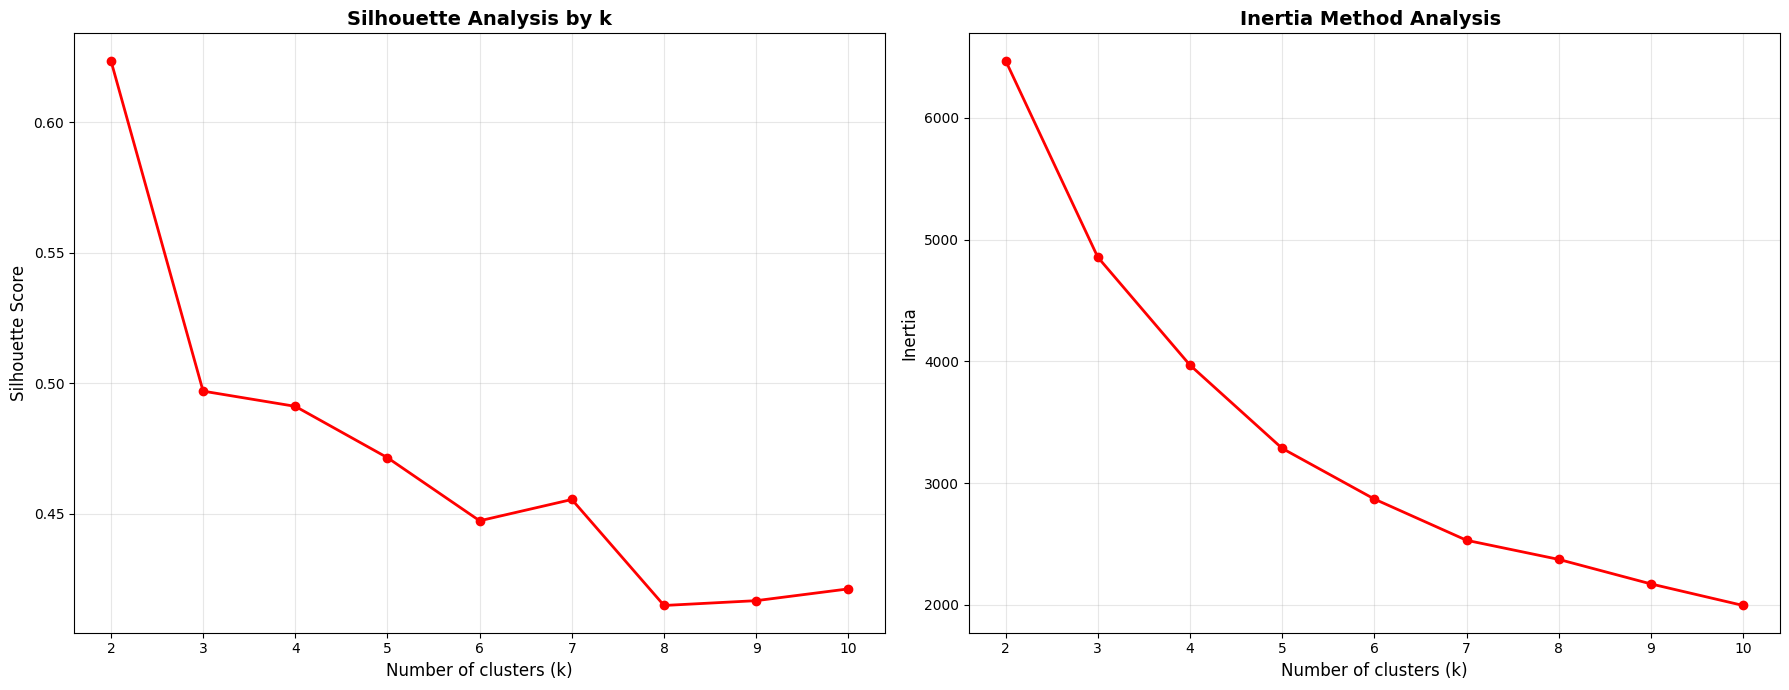

                    Performance Summary 

  for  k=2 :   Inertia =6471.799   | Silhouette score = 0.6236
  for  k=3 :   Inertia =4856.255   | Silhouette score = 0.4970
  for  k=4 :   Inertia =3969.304   | Silhouette score = 0.4911
  for  k=5 :   Inertia =3285.065   | Silhouette score = 0.4715
  for  k=6 :   Inertia =2868.581   | Silhouette score = 0.4473
  for  k=7 :   Inertia =2529.846   | Silhouette score = 0.4555
  for  k=8 :   Inertia =2372.694   | Silhouette score = 0.4149
  for  k=9 :   Inertia =2171.183   | Silhouette score = 0.4167
  for  k=10 :   Inertia =1994.064   | Silhouette score = 0.4212


In [41]:

#Visualization

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

#the range of clusters
k_values = range(2, 11)

#  Subplot 1: Silhouette Score Analysis 
ax1.plot(k_values, silhouette_scores, 'ro-', linewidth=2)
ax1.set_xlabel('Number of clusters (k)',fontsize=12)
ax1.set_ylabel('Silhouette Score',fontsize=12)
ax1.set_title('Silhouette Analysis by k',fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)


#  Subplot 2: Inertia (Elbow Method) Analysis
ax2.plot(k_values, cost, 'ro-', linewidth=2)
ax2.set_xlabel('Number of clusters (k)' , fontsize=12)
ax2.set_ylabel('Inertia',fontsize=12)
ax2.set_title('Inertia Method Analysis ',fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

#Final layout
plt.tight_layout()
plt.show()

print(""*3+"="*65)
print(" "*20 +"Performance Summary \n")


for k in range(0, 9) :
    print(f"  for  k={k+2} :   Inertia ={cost[k]:.3f}   | Silhouette score = {silhouette_scores[k]:.4f}")  

In [48]:
final_k = 4
kmeans_final = KMeans() \
    .setK(final_k) \
    .setSeed(1) \
    .setFeaturesCol("scaled_features") \
    .setPredictionCol("cluster")

# train the final model on your scaled data
final_model = kmeans_final.fit(rfm_scaled)

# Apply the model to generate cluster assignments
final_predictions = final_model.transform(rfm_scaled)





In [49]:
final_predictions.show(3)

+----------+-------+---------+------------------+-----------------+------------------+------------------+--------------------+--------------------+-------+
|CustomerID|Recency|Frequency|          Monetary|     Monetary_log|     Frequency_log|       Recency_log|       temp_features|     scaled_features|cluster|
+----------+-------+---------+------------------+-----------------+------------------+------------------+--------------------+--------------------+-------+
|     17389|      1|       34|31833.680000000004|10.36831154057086|3.5553480614894135|0.6931471805599453|[0.69314718055994...|[-2.4196962030263...|      0|
|     14450|    181|        3|            483.25|6.182601302287106|1.3862943611198906| 5.204006687076795|[5.20400668707679...|[1.02885709822027...|      1|
|     15727|     17|        7|           5159.06|8.548703486314981|2.0794415416798357|2.8903717578961645|[2.89037175789616...|[-0.7399174249894...|      0|
+----------+-------+---------+------------------+---------------

#### ***Cluster analysis*** 

This section consolidates all visual analyses to interpret the clusters.

In [50]:
# select the scaled_features and the cluster
df_pred_scaled = final_predictions.select("scaled_features", "cluster").toPandas()

# Extract individual RFM dimensions from the Spark Vector
df_pred_scaled['R'] = df_pred_scaled['scaled_features'].apply(lambda x: x[0])
df_pred_scaled['F'] = df_pred_scaled['scaled_features'].apply(lambda x: x[1])
df_pred_scaled['M'] = df_pred_scaled['scaled_features'].apply(lambda x: x[2])


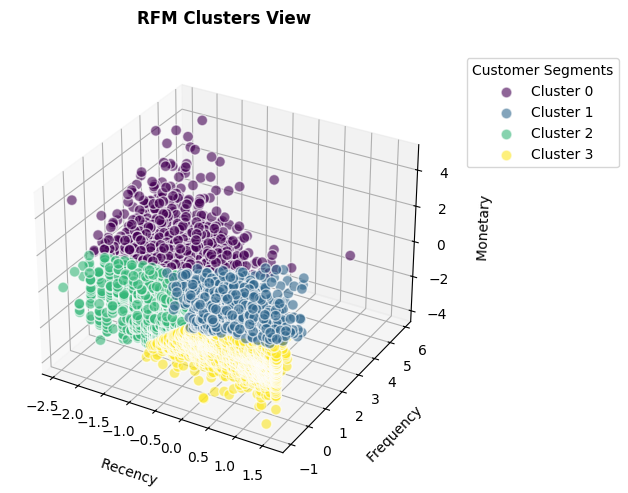

[2026-02-14 20:40:21,847] INFO:huey.consumer.Scheduler:Scheduler:Enqueueing periodic task mlflow.server.jobs.utils.online_scoring_scheduler: 3a51341c-ecb0-423f-81e2-d65ed09b9d85.


In [51]:
# Define  palette
cmap = plt.get_cmap('viridis')

#  Initialize the figure
fig = plt.figure(figsize=(9, 5))

# Add a 3D subplot 
ax = fig.add_subplot(111, projection='3d')

# Loop through each cluster to plot points
for i in range(4):
    # Filtering data for the current cluster from  df_pred_scaled
    subset = df_pred_scaled[df_pred_scaled['cluster'] == i]
    
    ax.scatter(subset['R'], 
               subset['F'], 
               subset['M'], 
               label=f'Cluster {i}', 
               color=cmap(i / 3), 
               s=60, 
               alpha=0.6, 
               edgecolors='w')

#  Setting labels for 
ax.set_xlabel('Recency ', fontsize=10, labelpad=10)
ax.set_ylabel('Frequency ', fontsize=10, labelpad=10)
ax.set_zlabel('Monetary ', fontsize=10, labelpad=10)
ax.set_title('RFM Clusters View', fontsize=12, fontweight='bold', pad=20)

# 6. Adding the legend
ax.legend(title="Customer Segments", loc='upper left', bbox_to_anchor=(1.05, 1))

# 7. Final  display
plt.tight_layout()
plt.show()

In [52]:
# group and aggregate RFM by cluster
cluster_stats = final_predictions.groupBy("cluster") \
    .agg(
        F.mean("Recency").alias("Avg_Recency"),
        F.mean("Frequency").alias("Avg_Frequency"),
        F.mean("Monetary").alias("Avg_Monetary"),
        F.count("cluster").alias("Customer_Count")
    ) \
    .orderBy("cluster")


# convert Aggregated stats to pandas
cluster_pands=cluster_stats.toPandas()
#store the simple count of customers per cluster (Calculate Population Distribution)
cluster_counts = final_predictions.groupBy("cluster").count().orderBy("cluster").toPandas()


[2026-02-14 20:40:26,204] INFO:huey:Worker-2:Executing mlflow.server.jobs.utils.online_scoring_scheduler: 3a51341c-ecb0-423f-81e2-d65ed09b9d85
[2026-02-14 20:40:26,210] INFO:huey:Worker-2:mlflow.server.jobs.utils.online_scoring_scheduler: 3a51341c-ecb0-423f-81e2-d65ed09b9d85 executed in 0.005s
[2026-02-14 20:41:21,847] INFO:huey.consumer.Scheduler:Scheduler:Enqueueing periodic task mlflow.server.jobs.utils.online_scoring_scheduler: b00ae53b-aada-46f5-9b0f-b76dccc51150.
[2026-02-14 20:41:23,937] INFO:huey:Worker-2:Executing mlflow.server.jobs.utils.online_scoring_scheduler: b00ae53b-aada-46f5-9b0f-b76dccc51150
[2026-02-14 20:41:23,940] INFO:huey:Worker-2:mlflow.server.jobs.utils.online_scoring_scheduler: b00ae53b-aada-46f5-9b0f-b76dccc51150 executed in 0.003s


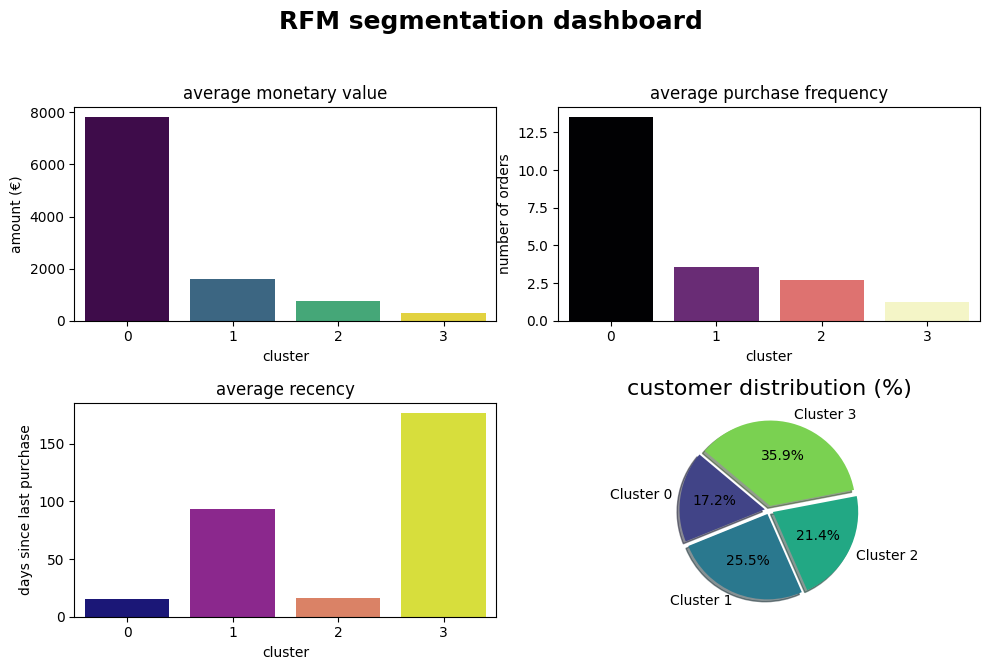

In [53]:
# Define the palette name to use across all plots
c_palette = 'viridis'

# Create the figure with a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
fig.suptitle('RFM segmentation dashboard ', fontsize=18, fontweight='bold')

#  Plot 1 : Visualizing the average spend per cluster

sns.barplot(ax=axes[0,0], x='cluster', y='Avg_Monetary', hue='cluster', 
            data=cluster_pands, palette=c_palette, legend=False)
axes[0,0].set_title('average monetary value')
axes[0,0].set_ylabel('amount (€)')
axes[0,0].set_xlabel('cluster')

#  Plot 2: # Visualizing the average number of orders per cluster
sns.barplot(ax=axes[0,1], x='cluster', y='Avg_Frequency', hue='cluster', 
            data=cluster_pands, palette='magma', legend=False)
axes[0,1].set_title('average purchase frequency')
axes[0,1].set_ylabel('number of orders')
axes[0,1].set_xlabel('cluster')

#  Plot 3:  Visualizing the average days since last purchase per cluster
sns.barplot(ax=axes[1,0], x='cluster', y='Avg_Recency', hue='cluster', 
            data=cluster_pands, palette='plasma', legend=False)
axes[1,0].set_title('average recency')
axes[1,0].set_ylabel('days since last purchase')
axes[1,0].set_xlabel('cluster')

#  Plot 4: Customer Distribution 
# Showing the percentage of total population for each cluster
axes[1, 1].pie(
    cluster_counts['count'], 
    labels=[f"Cluster {int(i)}" for i in cluster_counts['cluster']], 
    autopct='%1.1f%%', 
    startangle=140,
    colors=sns.color_palette(c_palette, n_colors=len(cluster_counts)),
    explode=[0.05] * len(cluster_counts),
    shadow=True
)
axes[1, 1].set_title('customer distribution (%)', fontsize=16)

# 
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


***STRATEGIC SEGMENTATION SUMMARY:***
* **Cluster 1 (Champions):** High value, high frequency, and very recent. Focus on VIP rewards.
* **Cluster 2 (Loyal):** Good frequency and spend. Focus on cross-selling products.
* **Cluster 3 (New):** Recent but low spend. Focus on welcome offers to increase frequency.
* **Cluster 0 (At Risk):** High recency and low engagement.

# ***Model Output & Export***


we map the clustering results back to the original dataset.
two final outputs
 * first (final_customer_df) : focused on the RFM metrics per customer
 * second (final_output_df)  :joins the cluster labels directly to the original raw dataset 

In [54]:
# Create the operational dataset (One row per customer)
final_customer_df = final_predictions.select(
    "CustomerID", 
    "Recency", 
    "Frequency", 
    "Monetary", 
    "cluster"
)

final_customer_df.show(5)

+----------+-------+---------+------------------+-------+
|CustomerID|Recency|Frequency|          Monetary|cluster|
+----------+-------+---------+------------------+-------+
|     17389|      1|       34|31833.680000000004|      0|
|     14450|    181|        3|            483.25|      1|
|     15727|     17|        7|           5159.06|      0|
|     15790|     11|        1|            218.75|      2|
|     13285|     24|        4|2709.1200000000003|      1|
+----------+-------+---------+------------------+-------+
only showing top 5 rows



In [55]:
#Join Original Data with Cluster Results
final_output_df = df_final.join(
    final_predictions.select("CustomerID", "cluster"), 
    on="CustomerID", 
    how="inner"
)

print("Final  Dataset - Preview:  (original data + Cluster):")
final_output_df.show(5)

Final  Dataset - Preview:  (original data + Cluster):


+----------+---------+---------+--------------------+--------+-------------------+---------+--------------+-------+
|CustomerID|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|       Country|cluster|
+----------+---------+---------+--------------------+--------+-------------------+---------+--------------+-------+
|     14688|   536378|   85071B|RED CHARLIE+LOLA ...|      96|2010-12-01 09:37:00|     0.38|United Kingdom|      0|
|     17850|   536396|    82482|WOODEN PICTURE FR...|       6|2010-12-01 10:51:00|      2.1|United Kingdom|      0|
|     15862|   536401|    22435|SET OF 9 HEART SH...|       2|2010-12-01 11:21:00|     1.25|United Kingdom|      2|
|     17850|   536406|    21871| SAVE THE PLANET MUG|       6|2010-12-01 11:33:00|     1.06|United Kingdom|      0|
|     17908|   536409|    22972|CHILDREN'S SPACEB...|       1|2010-12-01 11:45:00|     1.65|United Kingdom|      3|
+----------+---------+---------+--------------------+--------+----------

### ***Launch the MLflow server***

In [ ]:

def run_mlflow():
    os.system("mlflow ui --port 5000")

# Launch the MLflow server in a background process
p = multiprocessing.Process(target=run_mlflow)
p.start()

print("MLflow running at http://localhost:5000")